In [ ]:
!pip install librosa soundfile numpy scikit-learn seaborn matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define dataset path
DATASET_PATH = "/content/drive/My Drive/SER/speech-emotion-recognition-ravdess-data"

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import torch

# Check TensorFlow GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow GPU is available.")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("No TensorFlow GPU detected. Running on CPU.")

# Check PyTorch GPU
if torch.cuda.is_available():
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No PyTorch GPU detected. Running on CPU.")

TensorFlow GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch is using GPU: NVIDIA L4


In [ ]:
import numpy as np
import librosa
import soundfile

# Function to extract features from an audio file
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        result = np.array([])

        if mfcc:
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
            result = np.hstack((result, np.mean(mfccs.T, axis=0)))

        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
            result = np.hstack((result, np.mean(chroma.T, axis=0)))

        if mel:
            mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)
            result = np.hstack((result, np.mean(mel.T, axis=0)))

    return result


In [ ]:
import os
import glob
from sklearn.model_selection import train_test_split

# Emotion labels based on RAVDESS file naming convention
emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Select emotions to recognize
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

def load_data(test_size=0.2):
    x, y = [], []

    # Scan all WAV files in dataset
    for file in glob.glob(f"{DATASET_PATH}/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]  # Extract emotion label

        if emotion not in observed_emotions:
            continue  # Skip unwanted emotions

        feature = extract_feature(file)
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Load dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)
print(f"Dataset Loaded: {len(x_train)} training samples, {len(x_test)} test samples")


Dataset Loaded: 576 training samples, 192 test samples


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Initialize MLP model
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08,
                      hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# Train model
model.fit(x_train, y_train)

# Predict emotions
y_pred = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 78.12%


              precision    recall  f1-score   support

        calm       0.88      0.81      0.85        54
     disgust       0.70      0.68      0.69        38
     fearful       0.74      0.81      0.77        48
       happy       0.79      0.79      0.79        52

    accuracy                           0.78       192
   macro avg       0.78      0.77      0.78       192
weighted avg       0.78      0.78      0.78       192



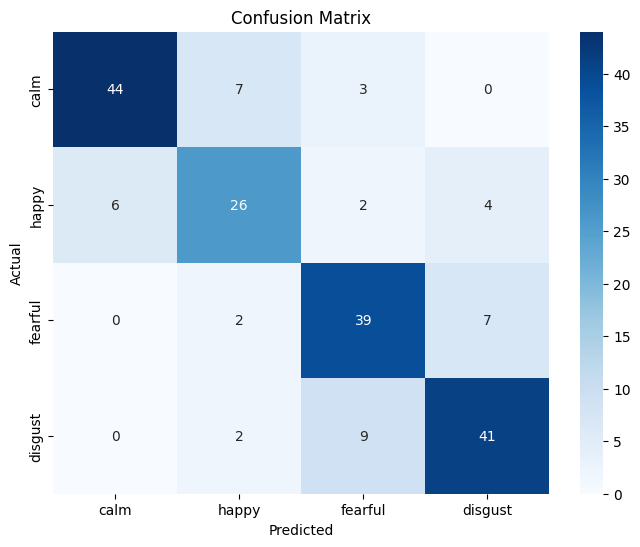

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Display classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=observed_emotions, yticklabels=observed_emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

# Save the trained model using joblib
model_filename = "/content/drive/My Drive/SER/speech_emotion_recognition_model.joblib"
joblib.dump(model, model_filename)

print(f"Model saved successfully at: {model_filename}")

Model saved successfully at: /content/drive/My Drive/SER/speech_emotion_recognition_model.joblib


In [ ]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Test the loaded model
sample_prediction = loaded_model.predict(x_test[:5])
print("Sample Predictions:", sample_prediction)
print("Actual Labels:", y_test[:5])

Sample Predictions: ['calm' 'fearful' 'happy' 'fearful' 'disgust']
Actual Labels: ['disgust', 'happy', 'happy', 'happy', 'disgust']
